# Applying BERT Multilingual Classifier to Predict Account Suspension 

Phase 2

Guidance from: https://github.com/kacossio/TeamPython/blob/master/Bert%20Multilingual%20Embedding.ipynb

## 1. Load Packages

In [296]:
########## Load Packages
import warnings
warnings.simplefilter("ignore")

import importlib
import pandas as pd
import numpy as np
import re
from io import StringIO
import itertools
import os 
import time
import datetime

from io import StringIO # python3; python2: BytesIO 
import boto3

import emoji
import random 
import math

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import math

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## 2. Set parameters

In [297]:
# Set Parameters 
########## Set Parameters

# Indicate how many rows to skip before columns
# Note: Python uses zero-based indexing, so skiprow=0 begins at the first row of file,
# while skiprow=1 begins at the second row.
skiprow=0

# Indicate name of column that contains text data for analysis
text_column = "text"

import_bucket = "data/s3_data/downsampled_full_clean/"

embedding_bucket = "data/s3_data/embeddings/final_embeddings_textclass/"

results_bucket = 'data/s3_data/' # already created on S3

## 3. Load in Data

### Load in data from S3 - Original Data

In [298]:
#### Load in data from S3

# Import Train and Measure Balance
# Import Flattened Data
df_train = pd.read_csv(import_bucket + "downsamp_df_train_full_cleaned_pe.csv", error_bad_lines=False, encoding='utf-8')

df_train['suspended'] = pd.to_numeric(df_train['suspended'], errors='coerce')
df_train = df_train[df_train['suspended'].notna()]

# Import Test and Measure Balance

df_test = pd.read_csv(import_bucket + "downsamp_df_test_full_cleaned_pe.csv", error_bad_lines=False, encoding='utf-8')

df_test['suspended'] = pd.to_numeric(df_test['suspended'], errors='coerce')
df_test = df_test[df_test['suspended'].notna()]

# Import Validation and Measure Balance
# Import Flattened Data
df_valid = pd.read_csv(import_bucket + "downsamp_df_valid_full_cleaned_pe.csv", error_bad_lines=False, encoding='utf-8')

df_valid['suspended'] = pd.to_numeric(df_valid['suspended'], errors='coerce')
df_valid = df_valid[df_valid['suspended'].notna()]

In [299]:
df_train = df_train.drop_duplicates(subset=['id'])
df_valid = df_valid.drop_duplicates(subset=['id'])
df_test = df_test.drop_duplicates(subset=['id'])

### Import Full Dataframes with Embeddings 

Multilingual

In [300]:
bert_embeddings_df_train = pd.read_csv(embedding_bucket + "multilingual_downsampled/results/ml_training_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_test = pd.read_csv(embedding_bucket + "multilingual_downsampled/results/ml_test_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_valid = pd.read_csv(embedding_bucket + "multilingual_downsampled/results/ml_valid_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')

In [301]:
bert_embeddings_df_train['id'] = bert_embeddings_df_train['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_train['id'] = bert_embeddings_df_train['id'].astype('float')
bert_embeddings_df_valid['id'] = bert_embeddings_df_valid['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_valid['id'] = bert_embeddings_df_valid['id'].astype('float')
bert_embeddings_df_test['id'] = bert_embeddings_df_test['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_test['id'] = bert_embeddings_df_test['id'].astype('float')

Labse

In [302]:
bert_embeddings_df_train_labse = pd.read_csv(embedding_bucket + "labse_downsampled/results/labse_train_embeddings_df.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_test_labse = pd.read_csv(embedding_bucket + "labse_downsampled/results/labse_test_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_valid_labse = pd.read_csv(embedding_bucket + "labse_downsampled/results/labse_valid_embeddings_df.csv", error_bad_lines=False, encoding='utf-8')

In [303]:
bert_embeddings_df_train_labse['id'] = bert_embeddings_df_train_labse['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_train_labse['id'] = bert_embeddings_df_train_labse['id'].astype('float')
bert_embeddings_df_valid_labse['id'] = bert_embeddings_df_valid_labse['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_valid_labse['id'] = bert_embeddings_df_valid_labse['id'].astype('float')
bert_embeddings_df_test_labse['id'] = bert_embeddings_df_test_labse['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_test_labse['id'] = bert_embeddings_df_test_labse['id'].astype('float')

### Check Lengths 

In [304]:
print("full train:", len(df_train), "unique ids train:", len(df_train['id'].unique()), 
      "full valid:", len(df_valid), "unique ids valid:", len(df_valid['id'].unique()), 
      "full test:", len(df_test), "unique ids test:", len(df_test['id'].unique()))

full train: 17615 unique ids train: 17615 full valid: 12410 unique ids valid: 12410 full test: 34839 unique ids test: 34839


In [305]:
print("full train:", len(bert_embeddings_df_train), "unique ids train:", len(bert_embeddings_df_train['id'].unique()), 
      "full valid:", len(bert_embeddings_df_valid), "unique ids valid:", len(bert_embeddings_df_valid['id'].unique()), 
      "full test:", len(bert_embeddings_df_test), "unique ids test:", len(bert_embeddings_df_test['id'].unique()))

full train: 17615 unique ids train: 17615 full valid: 12410 unique ids valid: 12410 full test: 34839 unique ids test: 34839


In [306]:
print("full train:", len(bert_embeddings_df_train_labse), "unique ids train:", len(bert_embeddings_df_train_labse['id'].unique()), 
      "full valid:", len(bert_embeddings_df_valid_labse), "unique ids valid:", len(bert_embeddings_df_valid_labse['id'].unique()), 
      "full test:", len(bert_embeddings_df_test_labse), "unique ids test:", len(bert_embeddings_df_test_labse['id'].unique()))

full train: 17615 unique ids train: 17615 full valid: 12410 unique ids valid: 12410 full test: 34839 unique ids test: 34839


## 5. Base Models: Fully Connected Models (No Fine-Tuning)

In [307]:
import pandas as pd
import re
import numpy as np
from sklearn import preprocessing
import pickle
import pandas as pd
import pickle
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow import keras
import random as rn
from keras.models import Model,save_model, load_model, Sequential
from keras.layers import Flatten,AveragePooling1D,Dropout,Dense,Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import IPython
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
from keras.utils import to_categorical
import pydot
import graphviz
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import kerastuner as kt
from kerastuner import HyperModel
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Get rid of perfect predictor vars 

In [308]:
bert_embeddings_df_train_fm = bert_embeddings_df_train.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_valid_fm = bert_embeddings_df_valid.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_test_fm = bert_embeddings_df_test.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                           "user.has_extended_profile_False", "user.protected_False", 
                                                           "user.verified_False", "user.geo_enabled_False",
                                                           "user.geo_enabled_True", "user.default_profile_True"], axis=1)

In [309]:
bert_embeddings_df_train_fm_labse = bert_embeddings_df_train_labse.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_valid_fm_labse = bert_embeddings_df_valid_labse.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_test_fm_labse = bert_embeddings_df_test_labse.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                           "user.has_extended_profile_False", "user.protected_False", 
                                                           "user.verified_False", "user.geo_enabled_False",
                                                           "user.geo_enabled_True", "user.default_profile_True"], axis=1)

### Prep Data to Convert to Tensor

In [310]:
pd.set_option('display.max_columns', None)
bert_embeddings_df_train.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_ml,lang_mr,lang_my,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_ta,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,withheld_in_countries_['DE'],withheld_in_countries_['IN'],withheld_in_countries_['TR'],place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,

In [311]:
#combined_features_train = bert_embeddings_df_train.drop(['suspended'], axis=1)
acct_features_train = bert_embeddings_df_train_fm.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_train_fm.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_train = bert_embeddings_df_train_fm.iloc[:, bert_embeddings_df_train_fm.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_train = bert_embeddings_df_train_fm['suspended']

#bert_embeddings_df_train.drop(['suspended'], axis=1).columns.get_loc(0)

#gets country label number
num_of_labels=labels_train.nunique()
num_of_labels

2

In [312]:
labels_train.unique()

array([1, 0])

#### Feature Selection

#### Option 1: Use Random Forest Feature Selection for Account Features 

I specify the random forest instance, indicating the number of trees. Then I use selectFromModel object from sklearn to automatically select the features.

To note, this is much faster than LASSO. 

In [313]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [314]:
#pd.set_option('display.max_rows', None)
acct_features_train.isna().sum()

created_at                              0
retweet_count                         229
favorite_count                        229
quoted_status_id                        0
user.favourites_count                   0
                                     ... 
place.country_United Arab Emirates      0
place.country_United States             0
user.verified_False.1                   0
is_quote_status_False                   0
is_quote_status_True                    0
Length: 150, dtype: int64

In [315]:
start_time = time.time()

acct_features_train['since_last_tweet_mins'] = pd.to_numeric(acct_features_train['since_last_tweet_mins'], errors='coerce')
acct_features_train['user.followers_countdailychange'] = pd.to_numeric(acct_features_train['user.followers_countdailychange'], errors='coerce')
acct_features_train['user.friends_countdailychange'] = pd.to_numeric(acct_features_train['user.friends_countdailychange'], errors='coerce')

acct_features_train = acct_features_train.replace([np.inf, -np.inf], np.nan)

acct_features_train = acct_features_train.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.020085811614990234 seconds ---


In [316]:
#generate random seed
def random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   rn.seed(seed)

random_seeds(1234)

In [317]:
feat_labels = acct_features_train.columns

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(acct_features_train, labels_train)
importances = forest.feature_importances_ # probably even simpler than the code I had

indices = np.argsort(importances)[::-1]

In [318]:
for f in range(acct_features_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) user.favourites_count          0.074919
 2) since_last_tweet_mins_max      0.071174
 3) no_urls_per_tweet              0.065547
 4) user.urls_per_tweet            0.064316
 5) avg_tweets_per_day             0.063021
 6) since_last_tweet_mins_mean     0.060708
 7) avg_tweets_per_hr              0.057312
 8) user.friends_countdailychange  0.047495
 9) user.followers_countdailychange 0.042740
10) user.screen_name.length        0.042451
11) no_mentions_per_tweet          0.041480
12) no_hashtags_per_tweet          0.038513
13) user.statuses_count            0.035305
14) user.friends_count             0.034160
15) user.followers_count           0.032768
16) followers_per_followees        0.032534
17) user.screen_name.digit_length  0.029422
18) created_at                     0.025668
19) user_age                       0.020667
20) tweets_per_day                 0.020203
21) user.followers_rate            0.017205
22) user.friend_rate               0.012169
23) user.listed_count          

In [319]:
sel = SelectFromModel(forest, prefit=True)
selected_feat= acct_features_train.columns[(sel.get_support())]
len(selected_feat)

26

In [320]:
selected_feat

Index(['created_at', 'user.favourites_count', 'user.followers_count',
       'user.friends_count', 'user.listed_count', 'user.statuses_count',
       'user_age', 'tweets_per_day', 'since_last_tweet_mins_max',
       'since_last_tweet_mins_mean', 'avg_tweets_per_hr', 'avg_tweets_per_day',
       'followers_per_followees', 'user.urls_per_tweet',
       'no_hashtags_per_tweet', 'no_mentions_per_tweet', 'no_urls_per_tweet',
       'user.followers_countdailychange', 'user.friends_countdailychange',
       'user.friend_rate', 'user.followers_rate',
       'user.screen_name.digit_length', 'user.screen_name.length',
       'source_Twitter for Android', 'source_Twitter for iPad',
       'source_Twitter for iPhone'],
      dtype='object')

In [321]:
scaler = StandardScaler()

acct_features_train = acct_features_train[selected_feat]

# Scale account features 
acct_features_train[acct_features_train.columns] = scaler.fit_transform(acct_features_train[acct_features_train.columns])

combined_features_train = pd.concat([acct_features_train, text_feature_train], axis=1)

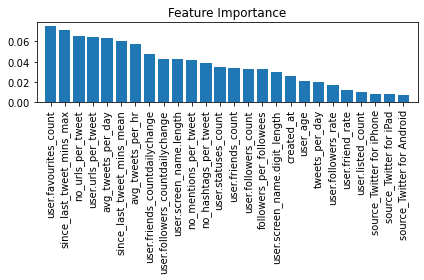

In [322]:
plt.title('Feature Importance')
plt.bar(range(acct_features_train.shape[1]), 
        importances[indices][0:len(selected_feat)],
        align='center')

plt.xticks(range(acct_features_train.shape[1]), 
           feat_labels[indices][0:len(selected_feat)], rotation=90)
plt.xlim([-1, acct_features_train.shape[1]])
plt.tight_layout()
plt.savefig(results_bucket + 'feature importance_downsamp.png', dpi=300)
plt.show()

#### Resume after feature selection

Valid

In [84]:
#combined_features_valid = bert_embeddings_df_valid.drop(['suspended'], axis=1)
acct_features_valid = bert_embeddings_df_valid_fm.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_valid_fm.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_valid = bert_embeddings_df_valid_fm.iloc[:, bert_embeddings_df_valid_fm.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_valid = bert_embeddings_df_valid_fm['suspended']

#gets country label number
num_of_labels_valid=labels_valid.nunique()
num_of_labels_valid

2

In [85]:
acct_features_valid = acct_features_valid[selected_feat]

### Interpolate Validation and Test to Match up with Train

In [86]:
#pd.set_option('display.max_rows', None)
acct_features_valid.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.listed_count                    0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            1
since_last_tweet_mins_mean           1
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees            129
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    109
user.friends_countdailychange      109
user.friend_rate                    19
user.followers_rate                132
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter for Android           0
source_Twitter for iPad              0
source_Twitter for iPhone

In [87]:
start_time = time.time()

acct_features_valid['user.followers_countdailychange'] = pd.to_numeric(acct_features_valid['user.followers_countdailychange'], errors='coerce')
acct_features_valid['user.friends_countdailychange'] = pd.to_numeric(acct_features_valid['user.friends_countdailychange'], errors='coerce')

acct_features_valid = acct_features_valid.replace([np.inf, -np.inf], np.nan)

acct_features_valid = acct_features_valid.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.007904052734375 seconds ---


In [88]:
len(acct_features_valid.columns)

26

Scale valid features

In [89]:
# Scale account features 
acct_features_valid[acct_features_valid.columns] = scaler.fit_transform(acct_features_valid[acct_features_valid.columns])

In [90]:
combined_features_valid = pd.concat([acct_features_valid, text_feature_valid], axis=1)

Test

In [91]:
acct_features_test = bert_embeddings_df_test_fm.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_test_fm.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_test = bert_embeddings_df_test_fm.iloc[:, bert_embeddings_df_test_fm.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_test = bert_embeddings_df_test_fm['suspended']

#gets country label number
num_of_labels_test=labels_test.nunique()
num_of_labels_test

2

In [92]:
acct_features_test = acct_features_test[selected_feat]

In [93]:
#pd.set_option('display.max_rows', None)
acct_features_test.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.listed_count                    0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            1
since_last_tweet_mins_mean           1
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees             45
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    291
user.friends_countdailychange      291
user.friend_rate                     6
user.followers_rate                378
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter for Android           0
source_Twitter for iPad              0
source_Twitter for iPhone

In [94]:
start_time = time.time()

acct_features_test['user.followers_countdailychange'] = pd.to_numeric(acct_features_test['user.followers_countdailychange'], errors='coerce')
acct_features_test['user.friends_countdailychange'] = pd.to_numeric(acct_features_test['user.friends_countdailychange'], errors='coerce')

acct_features_test = acct_features_test.replace([np.inf, -np.inf], np.nan)

acct_features_test = acct_features_test.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.020245790481567383 seconds ---


In [95]:
# Scale account features 
acct_features_test[acct_features_test.columns] = scaler.fit_transform(acct_features_test[acct_features_test.columns])

In [96]:
combined_features_test = pd.concat([acct_features_test, text_feature_test], axis=1)

In [97]:
len(acct_features_test.columns)

26

#### Calculate class weights to address class imbalance problem. 

In [98]:
mapping = {0:0, 1:1}

def data_prep(dataset):
    y = []
    for i in range(0,len(dataset)):
        y_val = np.zeros(2)
        y_val[mapping[dataset[i]]] = 1
        y.append(y_val)
    return np.array(y)

In [99]:
labels_train_fw = data_prep(labels_train)
len(labels_train_fw)

17615

In [100]:
class_counts = [0, 0]
for el in labels_train_fw :
    class_counts[np.argmax(el)]+=1
class_weights = {idx:sum(class_counts)/el for idx, el in enumerate(class_counts)}

#### Label Encoding

In [101]:
#Label encoding (Have not had work yet, but may on full data)
def label_encoding(labels):
    LE = LabelEncoder()
    fit=LE.fit(labels)
    labels =fit.transform(labels)
    labels = to_categorical(labels)
    return labels, fit

In [102]:
#Test label_encoding
labels_train, fit_train=label_encoding(labels_train)
labels_valid, fit_valid=label_encoding(labels_valid)
labels_test, fit_test=label_encoding(labels_test)

In [103]:
#generate random seed
def random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   rn.seed(seed)

#set seed
random_seeds(1234)

#### LabSe Processing

In [104]:
### Prep Data to Convert to Tensor

In [105]:
pd.set_option('display.max_columns', None)
bert_embeddings_df_train_labse.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_hy,lang_in,lang_is,lang_it,lang_iw,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_ml,lang_mr,lang_my,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_ta,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,withheld_in_countries_['DE'],withheld_in_countries_['IN'],withheld_in_countries_['TR'],place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,

In [106]:
#combined_features_train = bert_embeddings_df_train.drop(['suspended'], axis=1)
acct_features_train_labse = bert_embeddings_df_train_fm_labse.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_train_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_train_labse = bert_embeddings_df_train_fm_labse.iloc[:, bert_embeddings_df_train_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_train_labse = bert_embeddings_df_train_fm_labse['suspended']

In [107]:
acct_features_train_labse = acct_features_train_labse[selected_feat]

In [108]:
#pd.set_option('display.max_rows', None)
acct_features_train_labse.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.listed_count                    0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            0
since_last_tweet_mins_mean           0
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees             81
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    134
user.friends_countdailychange      134
user.friend_rate                     6
user.followers_rate                213
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter for Android           0
source_Twitter for iPad              0
source_Twitter for iPhone

In [109]:
start_time = time.time()

acct_features_train_labse['user.followers_countdailychange'] = pd.to_numeric(acct_features_train_labse['user.followers_countdailychange'], errors='coerce')
acct_features_train_labse['user.friends_countdailychange'] = pd.to_numeric(acct_features_train_labse['user.friends_countdailychange'], errors='coerce')

acct_features_train_labse = acct_features_train_labse.replace([np.inf, -np.inf], np.nan)

acct_features_train_labse = acct_features_train_labse.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.008054018020629883 seconds ---


In [110]:
len(acct_features_train_labse.columns)

26

Standardize Features

In [111]:
acct_features_train_labse[acct_features_train_labse.columns] = scaler.fit_transform(acct_features_train_labse[acct_features_train_labse.columns])

In [112]:
combined_features_train_labse = pd.concat([acct_features_train_labse, text_feature_train_labse], axis=1)

In [113]:
#combined_features_valid = bert_embeddings_df_valid.drop(['suspended'], axis=1)
acct_features_valid_labse = bert_embeddings_df_valid_fm_labse.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_valid_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_valid_labse = bert_embeddings_df_valid_fm_labse.iloc[:, bert_embeddings_df_valid_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_valid_labse = bert_embeddings_df_valid_fm_labse['suspended']

In [114]:
acct_features_valid_labse = acct_features_valid_labse[selected_feat]

### Interpolate Validation and Test to Match up with Train

In [115]:
acct_features_valid_labse.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.listed_count                    0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            1
since_last_tweet_mins_mean           1
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees            129
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    109
user.friends_countdailychange      109
user.friend_rate                    19
user.followers_rate                132
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter for Android           0
source_Twitter for iPad              0
source_Twitter for iPhone

In [116]:
start_time = time.time()

acct_features_valid_labse['user.followers_countdailychange'] = pd.to_numeric(acct_features_valid_labse['user.followers_countdailychange'], errors='coerce')
acct_features_valid_labse['user.friends_countdailychange'] = pd.to_numeric(acct_features_valid_labse['user.friends_countdailychange'], errors='coerce')

acct_features_valid_labse = acct_features_valid_labse.replace([np.inf, -np.inf], np.nan)

acct_features_valid_labse = acct_features_valid_labse.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.005368947982788086 seconds ---


In [117]:
len(acct_features_valid_labse.columns)

26

Standardize Features

In [118]:
acct_features_valid_labse[acct_features_valid_labse.columns] = scaler.fit_transform(acct_features_valid_labse[acct_features_valid_labse.columns])

In [119]:
combined_features_valid_labse = pd.concat([acct_features_valid_labse, text_feature_valid_labse], axis=1)

In [120]:
acct_features_test_labse = bert_embeddings_df_test_fm_labse.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_test_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_test_labse = bert_embeddings_df_test_fm_labse.iloc[:, bert_embeddings_df_test_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_test_labse = bert_embeddings_df_test_fm_labse['suspended']

In [121]:
acct_features_test_labse = acct_features_test_labse[selected_feat]

In [122]:
#pd.set_option('display.max_rows', None)
acct_features_test_labse.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.listed_count                    0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            1
since_last_tweet_mins_mean           1
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees             45
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    291
user.friends_countdailychange      291
user.friend_rate                     6
user.followers_rate                378
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter for Android           0
source_Twitter for iPad              0
source_Twitter for iPhone

In [123]:
start_time = time.time()

acct_features_test_labse['user.followers_countdailychange'] = pd.to_numeric(acct_features_test_labse['user.followers_countdailychange'], errors='coerce')
acct_features_test_labse['user.friends_countdailychange'] = pd.to_numeric(acct_features_test_labse['user.friends_countdailychange'], errors='coerce')

acct_features_test_labse = acct_features_test_labse.replace([np.inf, -np.inf], np.nan)

acct_features_test_labse = acct_features_test_labse.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.013224363327026367 seconds ---


In [124]:
len(acct_features_test_labse.columns)

26

Standardize Features

In [125]:
acct_features_test_labse[acct_features_test_labse.columns] = scaler.fit_transform(acct_features_test_labse[acct_features_test_labse.columns])

In [126]:
combined_features_test_labse = pd.concat([acct_features_test_labse, text_feature_test_labse], axis=1)

In [127]:
labels_train_fw_labse = data_prep(labels_train_labse)
len(labels_train_fw_labse)

17615

In [128]:
class_counts = [0, 0]
for el in labels_train_fw_labse :
    class_counts[np.argmax(el)]+=1
class_weights_labse = {idx:sum(class_counts)/el for idx, el in enumerate(class_counts)}

In [129]:
#Test label_encoding
labels_train_labse, fit_train_labse=label_encoding(labels_train_labse)
labels_valid_labse, fit_valid_labse=label_encoding(labels_valid_labse)
labels_test_labse, fit_test_labse=label_encoding(labels_test_labse)

#### Account only model  

In [130]:
#make sure numpy array
train_data_acc = np.array(acct_features_train).astype(np.float32)
valid_data_acc = np.array(acct_features_valid).astype(np.float32)
test_data_acc = np.array(acct_features_test).astype(np.float32)

train_labels = labels_train
valid_labels = labels_valid
test_labels = labels_test

In [131]:
#input shape for account features
input_shape_acc=train_data_acc[0].shape
input_shape_acc

(26,)

In [132]:
#Function for model flow. Does not include any parameter tuning
def model_flow(model_name, num_of_labels, input_shape):
    inputs = keras.Input(shape=(input_shape), name="Combined_inputs")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(32, activation="relu",name="dense_2")(x)
    x = layers.Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(0.15)(x) # SHOULD WE CONSIDER INCREASING TOP 0.5?
    outputs = layers.Dense(num_of_labels, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

# DO WE NEED DROPOUT AFTER EACH LAYER INSTEAD OF RIGHT AT THE END? 

In [133]:
#model flow and summary
Acc_model = model_flow("Account_Info",num_of_labels, input_shape_acc)
Acc_model.summary()

Model: "Account_Info"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 26)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1728      
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                

In [134]:
#Compile  model
Acc_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [135]:
#Fitting on training and validation data
print("Fit model on Account Information features training data")
history_acc = Acc_model.fit(train_data_acc, train_labels, epochs=2, batch_size=15,
                   validation_data=(valid_data_acc, valid_labels), class_weight=class_weights)

Fit model on Account Information features training data
Epoch 1/2
1175/1175 [==============================] - 3s 2ms/step - loss: 0.5715 - accuracy: 0.8858 - val_loss: 1.6176 - val_accuracy: 0.6347
Epoch 2/2
1175/1175 [==============================] - 2s 2ms/step - loss: 0.1211 - accuracy: 0.9779 - val_loss: 2.2767 - val_accuracy: 0.6440


In [136]:
# Evaluate the model on the test data
print("Evaluate on Account Information features test data")
Acc_model_results = Acc_model.evaluate(test_data_acc, test_labels, batch_size=10)

Evaluate on Account Information features test data
3484/3484 [==============================] - 3s 746us/step - loss: 3.3799 - accuracy: 0.5118


#### Save Model 

In [137]:
from tensorflow.keras.layers import LeakyReLU
Acc_model.save('data/s3_data/model_output/down_test_interp_Acc_model.h5')  # creates a HDF5 file 'my_model.h5'

#### Load back in model 

In [138]:
from tensorflow.keras.models import load_model

Acc_model = load_model('data/s3_data/model_output/down_test_interp_Acc_model.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Make Predictions

For Tweets

In [139]:
# Generate predictions (location probabilities)
def predict_test(model,test_data, test_labels, fit):
    predictions = model.predict(test_data)
    #y_true=np.argmax(test_labels, axis=0) 
    #y_pred=np.argmax(predictions, axis =0)
    #get labels of prediction
    #label_pred=fit.inverse_transform(y_pred)
    #metrics
    report = classification_report(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
    return report # label_pred

In [140]:
#test predict_test
metrics_report_acc=predict_test(Acc_model,test_data_acc,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_acc)


              precision    recall  f1-score   support

           0       0.96      0.49      0.64     31795
           1       0.13      0.78      0.22      3044

    accuracy                           0.51     34839
   macro avg       0.54      0.63      0.43     34839
weighted avg       0.89      0.51      0.61     34839



In [141]:
predictions = Acc_model.predict(test_data_acc)

In [142]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)  

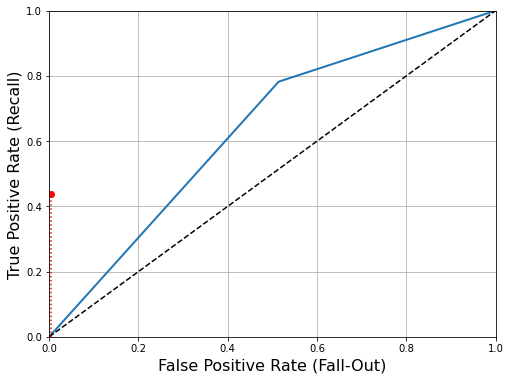

In [143]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [144]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.6340599704620538

For Accounts

In [145]:
# Generate summed probabilities at the account level 
def predict_account(model, df_mod, df_bert, df_full):
    predictions = model.predict(df_mod)[:,1]
    df = pd.DataFrame(predictions, columns = ['pred'])
    df_2 = pd.merge(df_bert.reset_index()['user.id'], df, left_index=True, right_index=True)
    df_fm = df_full[['user.screen_name','user.id', 'suspended']].drop_duplicates(subset=['user.screen_name','user.id'])
    df_3 = pd.merge(df_fm, df_2, left_on='user.id', right_on='user.id')
    df_4 = df_3[['user.screen_name', 'suspended','pred']].groupby('user.screen_name').agg(['sum', 'mean'])
    df_4.drop(('suspended', 'sum'), axis = 1, inplace = True)
    df_4.columns = df_4.columns = [' '.join(col).strip() for col in df_4.columns.values]
    df_4.reset_index(level=0, inplace=True)
    df_4.columns = ["user.screen_name","suspended_label", "total_pre_prob","mean_pred_prob"]
    df_4['pred_class'] = np.where(df_4['mean_pred_prob'] > 0.25, 1,0) # Use lighter threshold as not all tweets get an account suspended. 
    df_4 = df_4.sort_values(by=['total_pre_prob'], ascending=False)

    return df_4

In [146]:
# Generate summed probabilities at the account level 
def predict_tweet_text(model, df_mod, df_bert, df_full):
    predictions = model.predict(df_mod)[:,1]
    df = pd.DataFrame(predictions, columns = ['pred'])
    df_2 = pd.merge(df_bert.reset_index()['id'], df, left_index=True, right_index=True)
    df_fm = df_full[['id', 'text','user.screen_name','user.id', 'suspended']].drop_duplicates(subset=['user.screen_name','user.id'])
    df_fm['id'] = df_fm['id'].apply(lambda x: x.replace("'", ''))
    df_fm['id'] = df_fm['id'].astype('float')
    df_fm['id'] = df_fm['id'].astype('str')
    df_fm['id'] = df_fm['id'].apply(lambda x: "'" + x + "'")
    df_2['id'] = df_2['id'].astype('str')
    df_2['id'] = df_2['id'].apply(lambda x: "'" + x + "'")
    df_3 = pd.merge(df_fm, df_2, left_on='id', right_on='id')
    df_3.columns = ["id", "text", "user.screen_name", "user.id", "suspended_label", "pred"]
    df_3 = df_3.sort_values(by=['pred'], ascending=False)

    return df_3

In [147]:
test_preds_tweets = predict_tweet_text(Acc_model, test_data_acc, bert_embeddings_df_test, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
140,'1.2801950376791245e+18',美国女子被拒绝进门后疯狂撞门舔玻璃，被网友称：僵尸电影真人版 https://t.co/i1...,psJAtszK9QfWoK7,1.279980e+18,1,1.0
182,'1.2820746339365724e+18',RT @GordonGChang: A good friend of mine has to...,rainman02661756,1.280414e+18,1,1.0
430,'1.304426126786224e+18',@thescribe01 @iutiku @USA_China_Talk @SecPompe...,fullaheadspeed,1.285116e+18,0,1.0
75,'1.286200046141051e+18',https://t.co/cDwJi4AVsq,iwv6XuLnvqMijxe,1.278925e+18,0,1.0
400,'1.2996020869554217e+18',@globaltimesnews Please stop the internet viol...,s56BBFn8Ryhv4w1,1.284401e+18,0,1.0


In [148]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/down_test_interp/test_tweets_preds_acc.csv', index=False, encoding = "utf_8_sig")

In [149]:
test_account_preds_acc = predict_account(Acc_model, test_data_acc, bert_embeddings_df_test, df_test)

In [150]:
test_account_preds_acc.to_csv(results_bucket + 'account_level_results/down_test_interp/test_account_preds_acc.csv', index=False, encoding = "utf_8_sig")

In [151]:
#report = classification_report(np.array(test_labels), predictions)
report_te_acc = classification_report(np.array(test_account_preds_acc['suspended_label']), np.array(test_account_preds_acc['pred_class']))
print(report_te_acc)

              precision    recall  f1-score   support

           0       0.94      0.56      0.70       479
           1       0.08      0.53      0.14        34

    accuracy                           0.56       513
   macro avg       0.51      0.55      0.42       513
weighted avg       0.89      0.56      0.67       513



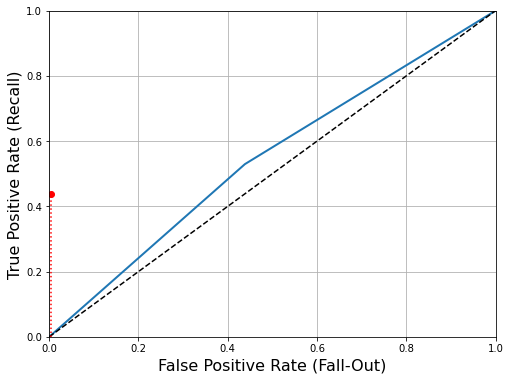

In [152]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_acc['suspended_label']), np.array(test_account_preds_acc['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [153]:
roc_auc_score(np.array(test_account_preds_acc['suspended_label']), np.array(test_account_preds_acc['pred_class']))

0.54549920176839

Tweet Model Results

In [154]:
def accuracy_plot(title_, history_fit):
    plt.plot(history_fit.history['accuracy'])
    plt.plot(history_fit.history['val_accuracy'])
    plt.title(title_)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()
    return plt

# CREATE A LOSS PLOT AS WELL!!!!!

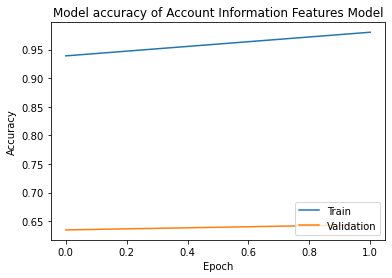

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [3.379901647567749, 0.5118114948272705]


In [155]:
#train vs validation accuracy plot
plot_acc=accuracy_plot('Model accuracy of Account Information Features Model', history_acc)
print(plot_acc)
#test accuracy and loss 
print("test loss, test accuracy:", Acc_model_results)

In [156]:
def loss_plot(title_, history_fit):
    plt.plot(history_fit.history['loss'])
    plt.plot(history_fit.history['val_loss'])
    plt.title(title_)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()
    return plt

# CREATE A LOSS PLOT AS WELL!!!!!

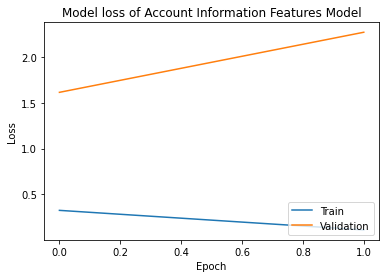

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [3.379901647567749, 0.5118114948272705]


In [157]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Account Information Features Model', history_acc)
print(plot_loss)
#test accuracy and loss
print("test loss, test accuracy:", Acc_model_results)

#### Combined Model

Multilingual

In [158]:
#make sure numpy array
train_data = np.array(combined_features_train).astype(np.float32)
valid_data = np.array(combined_features_valid).astype(np.float32)
test_data = np.array(combined_features_test).astype(np.float32)

train_labels = labels_train
valid_labels = labels_valid
test_labels = labels_test

In [159]:
#gets shape of the data for the model
input_shape_combined=train_data[0].shape
input_shape_combined

(794,)

In [160]:
train_data[0].shape

(794,)

In [161]:
#set seed
random_seeds(1234)

In [162]:
#test model_flow
Combined_model = model_flow("Combined",num_of_labels, input_shape_combined)

In [163]:
#model summary
Combined_model.summary()


Model: "Combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 794)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50880     
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 34 

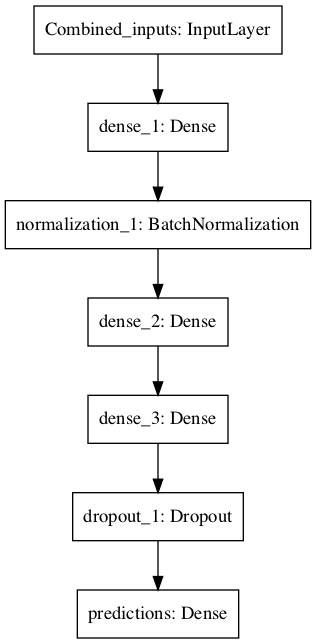

In [164]:
#model diagram
tf.keras.utils.plot_model(Combined_model)

In [165]:
#Compile  model
Combined_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [166]:
#Fitting on training and validation data
print("Fit model on training data")
history_combined = Combined_model.fit(train_data, train_labels, epochs=2, batch_size=15,
                                      validation_data=(valid_data, valid_labels), class_weight = class_weights)

Fit model on training data
Epoch 1/2
1175/1175 [==============================] - 4s 2ms/step - loss: 0.6453 - accuracy: 0.8655 - val_loss: 1.3261 - val_accuracy: 0.5245
Epoch 2/2
1175/1175 [==============================] - 3s 2ms/step - loss: 0.3914 - accuracy: 0.9212 - val_loss: 2.1716 - val_accuracy: 0.5058


In [167]:
# Evaluate the model on the test data
print("Evaluate on test data")
model_results_comb = Combined_model.evaluate(test_data, test_labels, batch_size=10)

Evaluate on test data
3484/3484 [==============================] - 3s 885us/step - loss: 1.6097 - accuracy: 0.5252


#### Save Model 

In [168]:
from tensorflow.keras.layers import LeakyReLU
Combined_model.save('data/s3_data/model_output/down_test_interp_Combined_model.h5')  # creates a HDF5 file 'my_model.h5'

#### Load Model 

In [169]:
from tensorflow.keras.models import load_model

Combined_model = load_model('data/s3_data/model_output/down_test_interp_Combined_model.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Predictions

Tweets

In [170]:
#test predict_test
metrics_report_comb=predict_test(Combined_model,test_data,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_comb)

              precision    recall  f1-score   support

           0       0.95      0.51      0.66     31795
           1       0.12      0.71      0.21      3044

    accuracy                           0.53     34839
   macro avg       0.53      0.61      0.43     34839
weighted avg       0.88      0.53      0.62     34839



In [171]:
predictions = Combined_model.predict(test_data)

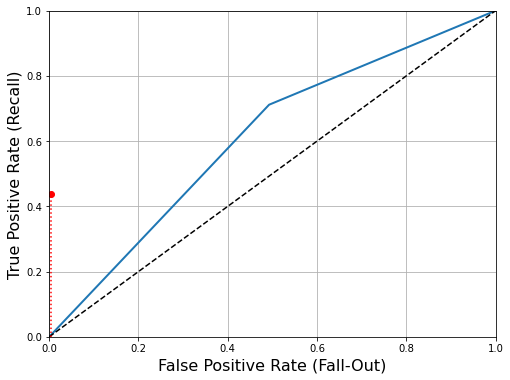

In [172]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [173]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.6094852784520745

In [174]:
test_preds_tweets = predict_tweet_text(Combined_model, test_data, bert_embeddings_df_test, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
327,'1.3059035235995402e+18',@SZ_______227 @ZaBa6EK40gM5P1l @william9890139...,GPJb9VHo6PbSu2W,1.283044e+18,0,1.000000
350,'1.284369157723689e+18',@CMPunjabPK آپ کی حکومت نے ابھی تک تو کوہسلیم...,JavedBa52971349,1.283357e+18,0,1.000000
186,'1.2970875723683963e+18',RT @aaminah_tariq: دور حاضر میں وہی شخص سر اٹھ...,truthseeker3731,1.280455e+18,0,0.999998
60,'1.278708441478029e+18',@PTAofficialpk #unbanpubg,SohaibAjab,1.278705e+18,0,0.999994
502,'1.2867327895140352e+18',RT @SaleemKhanSafi: آج کل پھر کلبھوشن کلبھوشن ...,GhulamMohiyddin,1.286723e+18,0,0.999991


In [175]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/down_test_interp/test_tweets_preds_comb.csv', index=False, encoding = "utf_8_sig")

Accounts

In [176]:
test_account_preds_comb = predict_account(Combined_model, test_data, bert_embeddings_df_test, df_test)

In [177]:
test_account_preds_comb.to_csv(results_bucket + 'account_level_results/down_test_interp/test_account_preds_comb.csv', index=False, encoding = "utf_8_sig")

In [178]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb = classification_report(np.array(test_account_preds_comb['suspended_label']), np.array(test_account_preds_comb['pred_class']))
print(report_te_comb)

              precision    recall  f1-score   support

           0       0.95      0.16      0.28       479
           1       0.07      0.88      0.13        34

    accuracy                           0.21       513
   macro avg       0.51      0.52      0.21       513
weighted avg       0.89      0.21      0.27       513



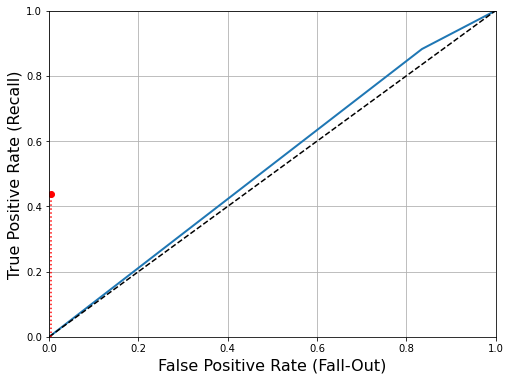

In [181]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb['suspended_label']), np.array(test_account_preds_comb['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [182]:
roc_auc_score(np.array(test_account_preds_comb['suspended_label']), np.array(test_account_preds_comb['pred_class']))

0.5236399361414712

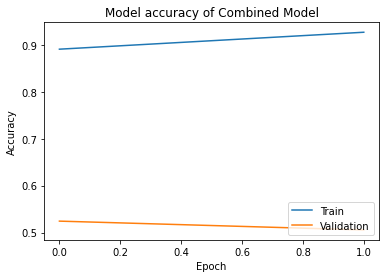

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [1.6096776723861694, 0.5252447128295898]


In [183]:
#train vs validation accuracy plot
plot_combined=accuracy_plot('Model accuracy of Combined Model', history_combined)
print(plot_combined)

print("test loss, test accuracy:", model_results_comb)

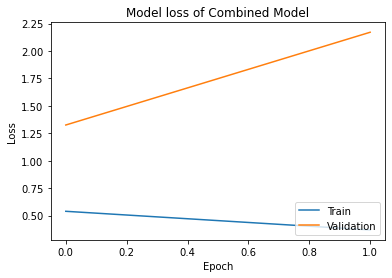

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [1.6096776723861694, 0.5252447128295898]


In [184]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Combined Model', history_combined)
print(plot_loss)
#test accuracy and loss 
print("test loss, test accuracy:", model_results_comb)

#### Labse

In [185]:
#make sure numpy array
train_data_labse = np.array(combined_features_train_labse).astype(np.float32)
valid_data_labse = np.array(combined_features_valid_labse).astype(np.float32)
test_data_labse = np.array(combined_features_test_labse).astype(np.float32)

train_labels_labse = labels_train_labse
valid_labels_labse = labels_valid_labse
test_labels_labse = labels_test_labse

In [186]:
#gets shape of the data for the model
input_shape_combined_labse=valid_data_labse[0].shape
input_shape_combined_labse

(794,)

In [187]:
#set seed
random_seeds(1234)

In [188]:
#test model_flow
Combined_model_labse = model_flow("Combined",num_of_labels, input_shape_combined_labse)

In [189]:
#model summary
Combined_model_labse.summary()

Model: "Combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 794)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50880     
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 34 

In [190]:
#Compile  model
Combined_model_labse.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [191]:
#Fitting on training and validation data
print("Fit model on training data")
history_combined_labse = Combined_model_labse.fit(train_data_labse, train_labels_labse, epochs=2, batch_size=15,
                                      validation_data=(valid_data_labse, valid_labels_labse), class_weight = class_weights_labse)

Fit model on training data
Epoch 1/2
1175/1175 [==============================] - 3s 2ms/step - loss: 0.5081 - accuracy: 0.8997 - val_loss: 1.6980 - val_accuracy: 0.5940
Epoch 2/2
1175/1175 [==============================] - 3s 2ms/step - loss: 0.2064 - accuracy: 0.9553 - val_loss: 2.0475 - val_accuracy: 0.5877


In [192]:
# Evaluate the model on the test data
print("Evaluate on test data")
model_results_comb_labse = Combined_model_labse.evaluate(test_data_labse, test_labels_labse, batch_size=10)

Evaluate on test data
3484/3484 [==============================] - 3s 890us/step - loss: 2.9436 - accuracy: 0.4579


In [193]:
from tensorflow.keras.layers import LeakyReLU
Combined_model_labse.save('data/s3_data/model_output/down_test_interp_Combined_model_labse.h5')  # creates a HDF5 file 'my_model.h5'

In [194]:
from tensorflow.keras.models import load_model

Combined_model_labse = load_model('data/s3_data/model_output/down_test_interp_Combined_model_labse.h5', custom_objects = {'LeakyReLU':LeakyReLU})

In [195]:
#test predict_test
metrics_report_comb_labse=predict_test(Combined_model_labse,test_data_labse,test_labels_labse, fit_test_labse)

# predicted_susp_tweettext
print(metrics_report_comb_labse)

              precision    recall  f1-score   support

           0       0.97      0.42      0.59     31795
           1       0.12      0.86      0.22      3044

    accuracy                           0.46     34839
   macro avg       0.55      0.64      0.40     34839
weighted avg       0.90      0.46      0.55     34839



In [196]:
predictions = Combined_model_labse.predict(test_data_labse)

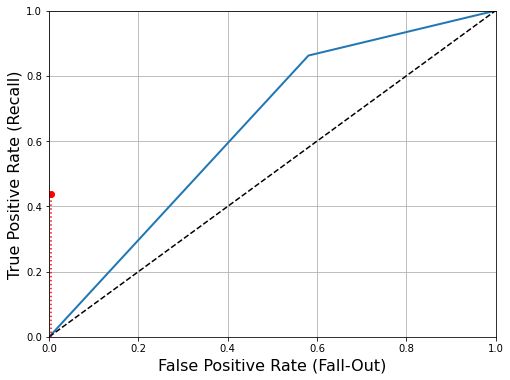

In [197]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [198]:
roc_auc_score(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))

0.6407687873550975

Accounts

In [199]:
test_preds_tweets = predict_tweet_text(Combined_model_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
424,'1.2865231570508431e+18',@bC63PSruJo8vm6w @Oarfishjuly 哈哈，暴露了吧，说话狗里狗气，句...,renhongyi122,1.284950e+18,0,1.0
327,'1.3059035235995402e+18',@SZ_______227 @ZaBa6EK40gM5P1l @william9890139...,GPJb9VHo6PbSu2W,1.283044e+18,0,1.0
75,'1.286200046141051e+18',https://t.co/cDwJi4AVsq,iwv6XuLnvqMijxe,1.278925e+18,0,1.0
480,'1.2870620476460728e+18',@zhang_heqing 张叔，晚安sleeping_face,Bigfish84774938,1.286307e+18,1,1.0
359,'1.288875553404027e+18',@PDChinese 炸的是核弹吗,RdXehTRD7MAE6nZ,1.283441e+18,1,1.0


In [200]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/down_test_interp/test_tweets_preds_comb_labse.csv', index=False, encoding = "utf_8_sig")

Test

In [201]:
test_account_preds_comb_labse = predict_account(Combined_model_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)

In [202]:
test_account_preds_comb_labse.to_csv(results_bucket + 'account_level_results/down_test_interp/test_account_preds_comb_labse.csv', index=False, encoding = "utf_8_sig")

In [203]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb_labse = classification_report(np.array(test_account_preds_comb_labse['suspended_label']), np.array(test_account_preds_comb_labse['pred_class']))
print(report_te_comb_labse)

              precision    recall  f1-score   support

           0       0.94      0.29      0.44       479
           1       0.07      0.76      0.13        34

    accuracy                           0.32       513
   macro avg       0.51      0.53      0.28       513
weighted avg       0.89      0.32      0.42       513



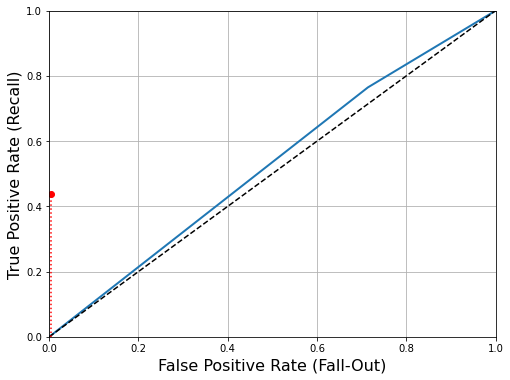

In [206]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb_labse['suspended_label']), np.array(test_account_preds_comb_labse['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [207]:
roc_auc_score(np.array(test_account_preds_comb_labse['suspended_label']), np.array(test_account_preds_comb_labse['pred_class']))

0.5253592042244872

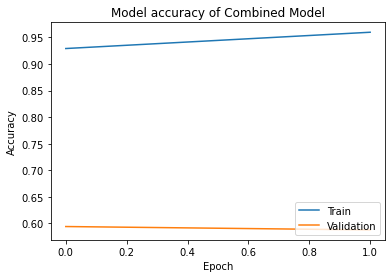

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [2.943601608276367, 0.4579063653945923]


In [208]:
#train vs validation accuracy plot
plot_combined=accuracy_plot('Model accuracy of Combined Model', history_combined_labse)
print(plot_combined)
#test accuracy
print("test loss, test accuracy:", model_results_comb_labse)

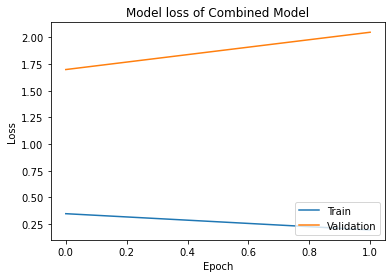

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [2.943601608276367, 0.4579063653945923]


In [209]:
#train vs validation loss plot
plot_loss=loss_plot('Model loss of Combined Model', history_combined_labse)
print(plot_loss)
#test loss and accuracy
print("test loss, test accuracy:", model_results_comb_labse)

### 3. Fine Tuning Models

In [210]:
#Callbacks
callback1=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4)

In [211]:
#clears training output
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

#### Account Only Model 

In [212]:
#input shape for account features
input_shape_acc=train_data_acc[0].shape
input_shape_acc

(26,)

In [213]:
def tuner_builder1(hp):
    inputs = keras.Input(shape=input_shape_acc, name="Tuned_Account_Info_Inputs")
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Account_Info_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return model

In [214]:
#tuner settings 
Acc_info_tuner = kt.Hyperband(
    tuner_builder1,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_acc_info3',
    project_name = 'Parameters_trials_acc_info0311382') # Need to be unique with each run!

In [215]:
#run through tuner
Acc_info_tuner.search(train_data_acc, train_labels,validation_data=(valid_data_acc, valid_labels),callbacks=[callback1,ClearTrainingOutput()])


Trial 90 Complete [00h 00m 05s]
val_accuracy: 0.5585011839866638

Best val_accuracy So Far: 0.7286059856414795
Total elapsed time: 00h 08m 10s
INFO:tensorflow:Oracle triggered exit


In [216]:
#gets best parameters
best_hyper_Acc_info = Acc_info_tuner.get_best_hyperparameters(1)[0]
best_hyper_Acc_info
    

In [217]:
print('Best Parameters for 1st Dense layer is', best_hyper_Acc_info.get('units'))

Best Parameters for 1st Dense layer is 50


In [218]:
print('Best Parameters for 2nd Dense layer is', best_hyper_Acc_info.get('units1'))

Best Parameters for 2nd Dense layer is 150


In [219]:
print('Best Parameters for 3rd Dense layer is', best_hyper_Acc_info.get('units2'))

Best Parameters for 3rd Dense layer is 80


In [220]:
print('Best Parameters for Dropout layer is', best_hyper_Acc_info.get('dropout'))

Best Parameters for Dropout layer is 0.2


In [221]:
print('Best learning rate for the ADAM is', best_hyper_Acc_info.get('learning_rate'))

Best learning rate for the ADAM is 0.0009142311834577992


In [222]:
#applies to tuning to model
Acc_info_model_tuned= Acc_info_tuner.hypermodel.build(best_hyper_Acc_info)

In [223]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned Account Information model")
history_acc_info_tuned = Acc_info_model_tuned.fit(train_data_acc, train_labels, epochs=2, batch_size=15,
                   validation_data=(valid_data_acc, valid_labels), class_weight = class_weights)

Fit model on training data with tuned Account Information model
Epoch 1/2
1175/1175 [==============================] - 2s 2ms/step - loss: 0.4886 - accuracy: 0.8952 - val_loss: 1.8351 - val_accuracy: 0.6326
Epoch 2/2
1175/1175 [==============================] - 2s 2ms/step - loss: 0.0962 - accuracy: 0.9824 - val_loss: 3.0589 - val_accuracy: 0.6156


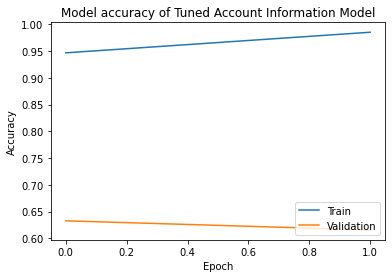

In [224]:
plot_acc_info_tuned=accuracy_plot('Model accuracy of Tuned Account Information Model', history_acc_info_tuned)

In [225]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned Account Information model on test data")
acc_info_tuned_results = Acc_info_model_tuned.evaluate(test_data_acc, test_labels, batch_size=10)

Evaluate tuned Account Information model on test data
3484/3484 [==============================] - 2s 588us/step - loss: 4.1899 - accuracy: 0.4424


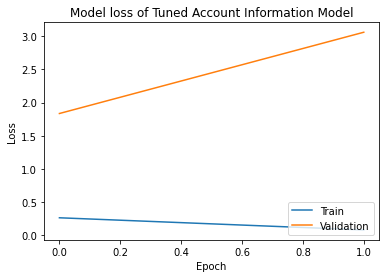

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [4.189886093139648, 0.4424065053462982]


In [226]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Tuned Account Information Model', history_acc_info_tuned)
print(plot_loss)
#valid accuracy and loss 
print("test loss, test accuracy:", acc_info_tuned_results)

#### Save Model 

In [227]:
from tensorflow.keras.layers import LeakyReLU
Acc_info_model_tuned.save('data/s3_data/model_output/down_test_interp_Acc_info_model_tuned.h5')  # creates a HDF5 file 'my_model.h5'

#### Load Model 

In [228]:
from tensorflow.keras.models import load_model
Acc_info_model_tuned = load_model('data/s3_data/model_output/down_test_interp_Acc_info_model_tuned.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Predict 

Tweets

In [229]:
#test predict_test
metrics_report_acc_tuned=predict_test(Acc_info_model_tuned,test_data_acc,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_acc_tuned)

              precision    recall  f1-score   support

           0       0.94      0.42      0.58     31795
           1       0.10      0.71      0.18      3044

    accuracy                           0.44     34839
   macro avg       0.52      0.56      0.38     34839
weighted avg       0.86      0.44      0.54     34839



In [230]:
predictions = Acc_info_model_tuned.predict(test_data_acc)

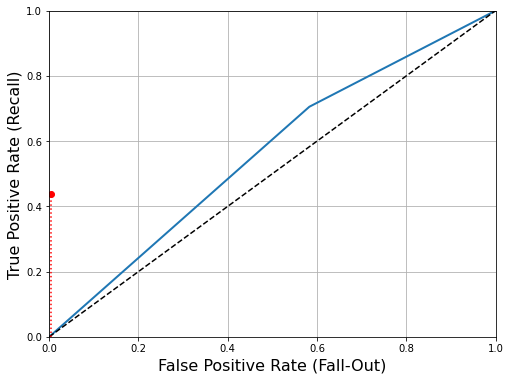

In [231]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [232]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.5612786795913951

In [233]:
test_preds_tweets = predict_tweet_text(Acc_info_model_tuned, test_data_acc, bert_embeddings_df_test, df_test)
test_preds_tweets.head()


,id,text,user.screen_name,user.id,suspended_label,pred
75,'1.286200046141051e+18',https://t.co/cDwJi4AVsq,iwv6XuLnvqMijxe,1.278925e+18,0,1.0
168,'1.2993934431987139e+18',@Gulalai_Ismail Anti state Paid Actor \n\n#PTM...,Interservicein2,1.280228e+18,0,1.0
482,'1.288847945379582e+18',#ImranKhanPUBGKeLiyaBolo\n@ImranKhanPTI \n@Zak...,Sameer09754082,1.286346e+18,0,1.0
214,'1.2826303770104259e+18',RT @kenklippenstein: https://t.co/XFc3zasULV,ianlazerbeem,1.280952e+18,0,1.0
386,'1.2859060971910595e+18',@xuebaoshang @hon1ybadg1r 首先以统一为前题，另外论军事的重要性，都...,cardolo5,1.284056e+18,0,1.0


In [234]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/down_test_interp/test_tweets_preds_acc_tuned.csv', index=False, encoding = "utf_8_sig")

Accounts

In [235]:
test_account_preds_acc_tuned = predict_account(Acc_info_model_tuned, test_data_acc, bert_embeddings_df_test, df_test)
test_account_preds_acc_tuned

,user.screen_name,suspended_label,total_pre_prob,mean_pred_prob,pred_class
100,GPJb9VHo6PbSu2W,0,2.211000e+03,1.000000e+00,1
367,fullaheadspeed,0,2.014000e+03,1.000000e+00,1
417,misswr0ng1,0,1.487602e+03,9.845148e-01,1
265,SophieDageraad,0,1.346177e+03,7.495415e-01,1
124,Interservicein2,0,1.209786e+03,9.998229e-01,1
...,...,...,...,...,...
330,baeco8,0,1.447614e-12,9.047591e-14,0
361,f8M8sfCRiUfooOb,0,1.731327e-13,2.885544e-14,0
184,MdTaimurKhan1,0,1.794559e-14,4.173394e-16,0
27,AliHaid79526468,0,1.984401e-15,1.804001e-16,0


In [236]:
test_account_preds_acc_tuned.to_csv(results_bucket + 'account_level_results/down_test_interp/test_account_preds_acc_tuned.csv', index=False, encoding = "utf_8_sig")

In [237]:
#report = classification_report(np.array(test_labels), predictions)
report_te_acc_tuned_tuned = classification_report(np.array(test_account_preds_acc_tuned['suspended_label']), np.array(test_account_preds_acc_tuned['pred_class']))
print(report_te_acc_tuned_tuned)

              precision    recall  f1-score   support

           0       0.93      0.38      0.54       479
           1       0.07      0.62      0.12        34

    accuracy                           0.40       513
   macro avg       0.50      0.50      0.33       513
weighted avg       0.88      0.40      0.52       513



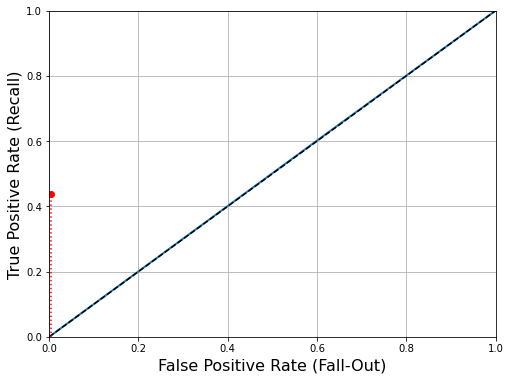

In [238]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_acc_tuned['suspended_label']), np.array(test_account_preds_acc_tuned['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [239]:
roc_auc_score(np.array(test_account_preds_acc_tuned['suspended_label']), np.array(test_account_preds_acc_tuned['pred_class']))

0.5008903352572762

#### Combined Model

Multilingual BERT

In [240]:
#gets shape of the data for the model
input_shape_combined=train_data[0].shape
input_shape_combined

(794,)

In [241]:
#Function to tune to the model
def tuner_builder(hp):
    inputs = keras.Input(shape=input_shape_combined, name="Tuned_Combined_Inputs") # They had 3333 (w CV) -> I hard coded my model shape. 
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x) # I get error now, but with full data there will be 2
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Combined_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [242]:
#tuner settings 
Combined_tuner = kt.Hyperband(
    tuner_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_combined3',
    project_name = 'Parameters_trials_combined_301005') # Need to be unique with each run!

In [243]:
#run through tuner
Combined_tuner.search(train_data, train_labels,validation_data=(valid_data, valid_labels),
             callbacks=[callback1,ClearTrainingOutput()])

Trial 90 Complete [00h 00m 06s]
val_accuracy: 0.550684928894043

Best val_accuracy So Far: 0.6045930981636047
Total elapsed time: 00h 09m 44s
INFO:tensorflow:Oracle triggered exit


In [244]:
#gets best parameters
best_hyper_combined = Combined_tuner.get_best_hyperparameters(1)[0]
best_hyper_combined

In [245]:
print('Best Parameters for 1st Dense layer is', best_hyper_combined.get('units'))

Best Parameters for 1st Dense layer is 70


In [246]:
print('Best Parameters for 2nd Dense layer is', best_hyper_combined.get('units1'))

Best Parameters for 2nd Dense layer is 150


In [247]:
print('Best Parameters for 3rd Dense layer is', best_hyper_combined.get('units2'))

Best Parameters for 3rd Dense layer is 80


In [248]:
print('Best Parameters for Dropout layer is', best_hyper_combined.get('dropout'))

Best Parameters for Dropout layer is 0.4


In [249]:
print('Best learning rate for the ADAM is', best_hyper_combined.get('learning_rate'))

Best learning rate for the ADAM is 0.00017042353228425582


In [250]:
#applies to tuning to model
Combined_model_tuned= Combined_tuner.hypermodel.build(best_hyper_combined)

In [251]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned model")
history_combined_tuned = Combined_model_tuned.fit(train_data, train_labels, epochs=2, batch_size=15,
                   validation_data=(valid_data, valid_labels), class_weight = class_weights)

Fit model on training data with tuned model
Epoch 1/2
1175/1175 [==============================] - 3s 2ms/step - loss: 0.7136 - accuracy: 0.8450 - val_loss: 1.1505 - val_accuracy: 0.5147
Epoch 2/2
1175/1175 [==============================] - 2s 2ms/step - loss: 0.4701 - accuracy: 0.9060 - val_loss: 1.3589 - val_accuracy: 0.5191


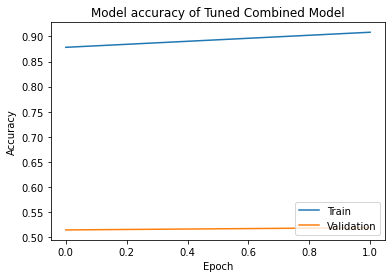

In [252]:
plot_combined_tuned=accuracy_plot('Model accuracy of Tuned Combined Model', history_combined_tuned)

In [253]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned model on test data")
Combined_model_tuned_results = Combined_model_tuned.evaluate(test_data, test_labels, batch_size=10)

Evaluate tuned model on test data
3484/3484 [==============================] - 2s 596us/step - loss: 1.3706 - accuracy: 0.4622


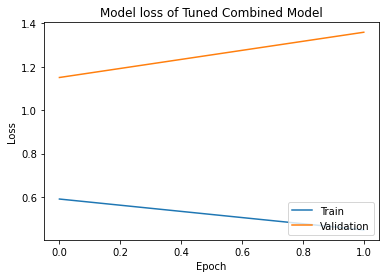

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [1.3706490993499756, 0.4621831774711609]


In [254]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Tuned Combined Model', history_combined_tuned)
print(plot_loss)
#valid accuracy and loss 
print("test loss, test accuracy:", Combined_model_tuned_results)

#### Save Model 

In [255]:
from tensorflow.keras.layers import LeakyReLU
Combined_model_tuned.save('data/s3_data/model_output/down_test_interp_Combined_model_tuned.h5')  # creates a HDF5 file 'my_model.h5'

#### Import Model 

In [256]:
from tensorflow.keras.models import load_model
Combined_model_tuned = load_model('data/s3_data/model_output/down_test_interp_Combined_model_tuned.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Predict

Tweets

In [257]:
#test predict_test
metrics_report_comb_tuned=predict_test(Combined_model_tuned,test_data,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_comb_tuned)

              precision    recall  f1-score   support

           0       0.96      0.43      0.59     31795
           1       0.12      0.83      0.21      3044

    accuracy                           0.46     34839
   macro avg       0.54      0.63      0.40     34839
weighted avg       0.89      0.46      0.56     34839



In [258]:
predictions = Combined_model_tuned.predict(test_data)

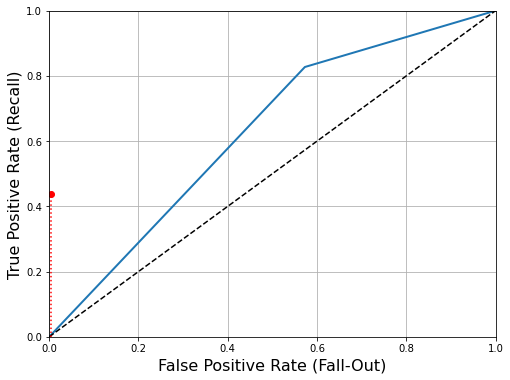

In [259]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [260]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.6272190190979954

In [261]:
test_preds_tweets = predict_tweet_text(Combined_model_tuned, test_data, bert_embeddings_df_test, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
350,'1.284369157723689e+18',@CMPunjabPK آپ کی حکومت نے ابھی تک تو کوہسلیم...,JavedBa52971349,1.283357e+18,0,0.999997
60,'1.278708441478029e+18',@PTAofficialpk #unbanpubg,SohaibAjab,1.278705e+18,0,0.999997
254,'1.281591647155843e+18',@xwpajq 非常喜欢你的节目！加油啊大宇！每天必看的！,zC9IkRcwgMgSGcQ,1.281587e+18,0,0.999994
186,'1.2970875723683963e+18',RT @aaminah_tariq: دور حاضر میں وہی شخص سر اٹھ...,truthseeker3731,1.280455e+18,0,0.999990
327,'1.3059035235995402e+18',@SZ_______227 @ZaBa6EK40gM5P1l @william9890139...,GPJb9VHo6PbSu2W,1.283044e+18,0,0.999983


In [262]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/down_test_interp/test_tweets_preds_comb_tuned.csv', index=False, encoding = "utf_8_sig")

Accounts

In [263]:
test_account_preds_comb_tuned = predict_account(Combined_model_tuned, test_data, bert_embeddings_df_test, df_test)

In [264]:
test_account_preds_comb_tuned.to_csv(results_bucket + 'account_level_results/down_test_interp/test_account_preds_comb_tuned.csv', index=False, encoding = "utf_8_sig")

In [265]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb = classification_report(np.array(test_account_preds_comb_tuned['suspended_label']), np.array(test_account_preds_comb_tuned['pred_class']))
print(report_te_comb)

              precision    recall  f1-score   support

           0       1.00      0.05      0.10       479
           1       0.07      1.00      0.13        34

    accuracy                           0.12       513
   macro avg       0.53      0.53      0.12       513
weighted avg       0.94      0.12      0.10       513



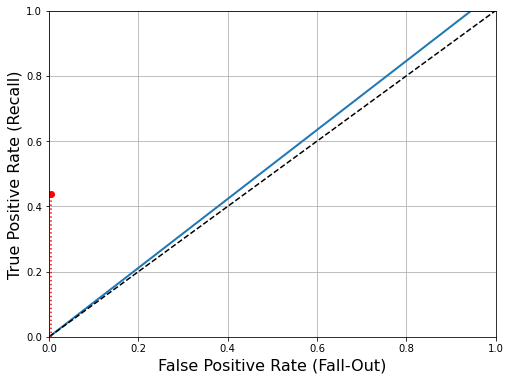

In [266]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb_tuned['suspended_label']), np.array(test_account_preds_comb_tuned['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [267]:
roc_auc_score(np.array(test_account_preds_comb_tuned['suspended_label']), np.array(test_account_preds_comb_tuned['pred_class']))

0.5271398747390397

Combined Model with LAbse

In [268]:
#gets shape of the data for the model
input_shape_combined_labse=train_data_labse[0].shape
input_shape_combined_labse

(794,)

In [269]:
#Function to tune to the model
def tuner_builder(hp):
    inputs = keras.Input(shape=input_shape_combined_labse, name="Tuned_Combined_Inputs") # They had 3333 (w CV) -> I hard coded my model shape. 
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x) # I get error now, but with full data there will be 2
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Combined_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [270]:
#tuner settings 
Combined_tuner = kt.Hyperband(
    tuner_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_combined2',
    project_name = 'Parameters_trials_combined_labse_9813') # Need to be unique with each run!

In [271]:
#run through tuner
Combined_tuner.search(train_data_labse, train_labels_labse,validation_data=(valid_data_labse, valid_labels_labse),
             callbacks=[callback1,ClearTrainingOutput()])

Trial 90 Complete [00h 00m 07s]
val_accuracy: 0.6414988040924072

Best val_accuracy So Far: 0.6922643184661865
Total elapsed time: 00h 09m 32s
INFO:tensorflow:Oracle triggered exit


In [272]:
#gets best parameters
best_hyper_combined_labse = Combined_tuner.get_best_hyperparameters(1)[0]
best_hyper_combined_labse

In [273]:
print('Best Parameters for 1st Dense layer is', best_hyper_combined_labse.get('units'))

Best Parameters for 1st Dense layer is 170


In [274]:
print('Best Parameters for 2nd Dense layer is', best_hyper_combined_labse.get('units1'))

Best Parameters for 2nd Dense layer is 150


In [275]:
print('Best Parameters for 3rd Dense layer is', best_hyper_combined_labse.get('units2'))

Best Parameters for 3rd Dense layer is 80


In [276]:
print('Best Parameters for Dropout layer is', best_hyper_combined_labse.get('dropout'))

Best Parameters for Dropout layer is 0.30000000000000004


In [277]:
print('Best learning rate for the ADAM is', best_hyper_combined_labse.get('learning_rate'))

Best learning rate for the ADAM is 0.0004795989885065387


In [278]:
#applies to tuning to model
Combined_model_tuned_labse= Combined_tuner.hypermodel.build(best_hyper_combined_labse)

In [279]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned model")
history_combined_tuned_labse = Combined_model_tuned_labse.fit(train_data_labse, train_labels_labse, epochs=2, batch_size=15,
                   validation_data=(valid_data_labse, valid_labels_labse), class_weight = class_weights_labse)

Fit model on training data with tuned model
Epoch 1/2
1175/1175 [==============================] - 4s 3ms/step - loss: 0.4620 - accuracy: 0.9001 - val_loss: 1.7204 - val_accuracy: 0.5595
Epoch 2/2
1175/1175 [==============================] - 3s 2ms/step - loss: 0.1403 - accuracy: 0.9715 - val_loss: 2.4608 - val_accuracy: 0.5359


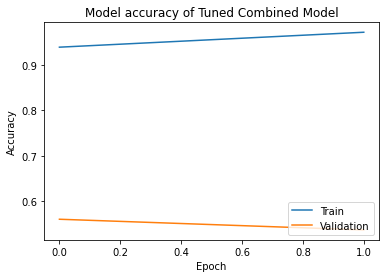

In [280]:
plot_combined_tuned_labse=accuracy_plot('Model accuracy of Tuned Combined Model', history_combined_tuned_labse)

In [281]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned model on test data")
Combined_model_tuned_results_labse = Combined_model_tuned_labse.evaluate(test_data_labse, test_labels_labse, batch_size=10)

Evaluate tuned model on test data
3484/3484 [==============================] - 3s 725us/step - loss: 2.8541 - accuracy: 0.4622


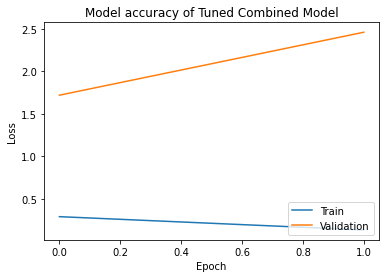

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [2.854102849960327, 0.4621831774711609]


In [282]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model accuracy of Tuned Combined Model', history_combined_tuned_labse)
print(plot_loss)
#valid accuracy and loss 
print("test loss, test accuracy:", Combined_model_tuned_results_labse)

In [283]:
from tensorflow.keras.layers import LeakyReLU
Combined_model_tuned_labse.save('data/s3_data/model_output/down_test_interp_Combined_model_tuned_labse.h5')  # creates a HDF5 file 'my_model.h5'

In [284]:
from tensorflow.keras.models import load_model
Combined_model_tuned_labse= load_model('data/s3_data/model_output/down_test_interp_Combined_model_tuned_labse.h5', custom_objects = {'LeakyReLU':LeakyReLU})

In [285]:
#test predict_test
metrics_report_comb_tuned_labse=predict_test(Combined_model_tuned_labse,test_data_labse,test_labels_labse, fit_test_labse)

# predicted_susp_tweettext
print(metrics_report_comb_tuned_labse)

              precision    recall  f1-score   support

           0       0.97      0.42      0.59     31795
           1       0.12      0.86      0.22      3044

    accuracy                           0.46     34839
   macro avg       0.55      0.64      0.40     34839
weighted avg       0.89      0.46      0.56     34839



In [286]:
predictions = Combined_model_tuned_labse.predict(test_data_labse)

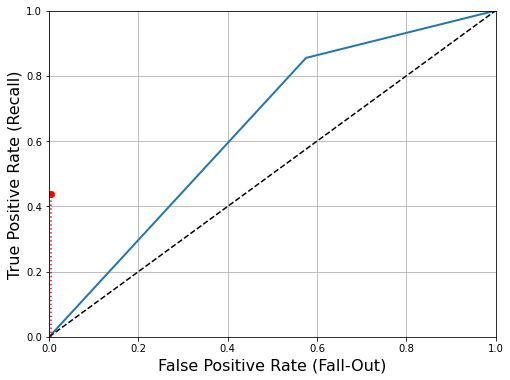

In [287]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [288]:
roc_auc_score(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))

0.6398442231865232

In [289]:
test_preds_tweets = predict_tweet_text(Combined_model_tuned_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
75,'1.286200046141051e+18',https://t.co/cDwJi4AVsq,iwv6XuLnvqMijxe,1.278925e+18,0,1.0
241,'1.281904271449981e+18',@soshk_hker 黄展家死全家\n香港油麗村朱偉文、黃展家、陳某三個淫賊長期在油麗村媾...,Chanxj1,1.281461e+18,1,1.0
140,'1.2801950376791245e+18',美国女子被拒绝进门后疯狂撞门舔玻璃，被网友称：僵尸电影真人版 https://t.co/i1...,psJAtszK9QfWoK7,1.279980e+18,1,1.0
32,'1.2865788815587901e+18',@eadksk_ Agree with you.,HafeezK26508932,1.278364e+18,0,1.0
12,'1.3081699799011533e+18',Who unfollowed you on Instagram? Learn unfollo...,HammadA88664018,1.278241e+18,0,1.0


In [290]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/down_test_interp/test_tweets_preds_comb_tuned_labse.csv', index=False, encoding = "utf_8_sig")

Test

In [291]:
test_account_preds_comb_tuned_labse = predict_account(Combined_model_tuned_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)

In [292]:
test_account_preds_comb_tuned_labse.to_csv(results_bucket + 'account_level_results/down_test_interp/test_account_preds_comb_tuned_labse.csv', index=False, encoding = "utf_8_sig")

In [293]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb_labse = classification_report(np.array(test_account_preds_comb_tuned_labse['suspended_label']), np.array(test_account_preds_comb_tuned_labse['pred_class']))
print(report_te_comb_labse)

              precision    recall  f1-score   support

           0       0.93      0.32      0.48       479
           1       0.06      0.65      0.12        34

    accuracy                           0.34       513
   macro avg       0.50      0.48      0.30       513
weighted avg       0.87      0.34      0.45       513



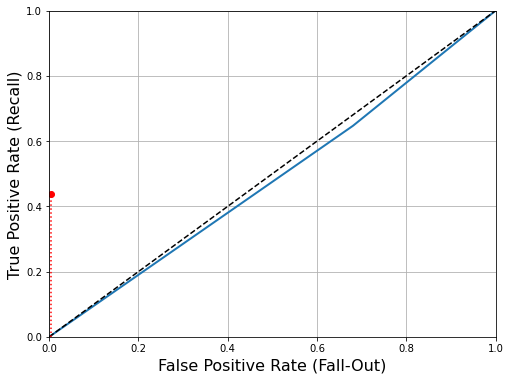

In [294]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb_tuned_labse['suspended_label']), np.array(test_account_preds_comb_tuned_labse['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [295]:
roc_auc_score(np.array(test_account_preds_comb_tuned_labse['suspended_label']), np.array(test_account_preds_comb_tuned_labse['pred_class']))

0.48323713619059316